In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#---------------To arrange the points clockwise---------------
def order_points(pts):
    if len(pts) == 4:
        pts = np.array(pts)
        rect = np.zeros((4, 2), dtype = "float32")
        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis = 1)
        rect[3] = pts[np.argmin(diff)]
        rect[1] = pts[np.argmax(diff)]
    else:
        pts = np.array(pts)
        rect = np.zeros((2, 2), dtype = "float32")
        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
    return rect

#-----------To check ehether the points are neighbor-----------
def isClose(pt, seed):
    if abs(pt[0]-seed[0]) >= 16 or abs(pt[1]-seed[1]) >= 16:
        return False
    return True

#---------To check whether th epoint is a corner or not---------
def isCorner(point, vals):
    se = set()
    for j in range(point[0]-5,point[0]+5):
        for k in range(point[1]-5,point[1]+5):
            se = se.union({vals[j][k]})
            if len(se) == 3:
                return True
    return False


def getCount(vals):
    li = [max(row) for row in vals]
    n = max(li)
    return int(n-2), 2


#-----------------To fetch the corners of the walls--------------
def findCorners(img, vals):
    img = cv2.resize(img, (320,320))

    h, w, c = img.shape

    imgGrey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgcanny = cv2.Canny(imgGrey, -150, 500)
    Epts = np.where(imgcanny != 0)
    c = cv2.cornerHarris(imgcanny, 5, 7, 0.07)
    k  = c>0.01*c.max()
    pts = np.where(k)

    Pts = [[pts[0][i], pts[1][i]] for i in range(len(pts[0]))]
    seeds, su, co, flag = [], [], [], False
    for pt in Pts:
        flag = True
        if len(seeds) == 0:
            x, y = pt[0], pt[1]
            seeds.append([x,y])
            su.append([x,y])
            co.append(1)
            continue
        for i in range(len(seeds)):
            if isClose(pt, seed=seeds[i]):
                flag = False
                su[i][0] = su[i][0] + pt[0]
                su[i][1] = su[i][1] + pt[1]
                co[i] += 1
                seeds[i][0] = su[i][0] // co[i]
                seeds[i][1] = su[i][1] // co[i]
                break
        if flag is True:
            x, y = pt[0], pt[1]
            seeds.append([x,y])
            su.append([x,y])
            co.append(1)


    outerPts = []

    current = vals[0][0]
    for i in range(1,len(vals[0])):
        if current != vals[0][i]:
            outerPts.append([0,i])
            current = vals[0][i]

    for i in range(1,len(vals)):
        if current != vals[i][319]:
            outerPts.append([i,319])
            current = vals[i][319]

    i = 319
    while(i >= 0):
        if current != vals[319][i]:
            outerPts.append([319,i])
            current = vals[319][i]
        i -= 1

    i = 319
    while(i >= 0):
        if current != vals[i][0]:
            outerPts.append([i,0])
            current = vals[i][0]
        i -= 1

    cornerPts = []
    for i in range(len(seeds)):
        if seeds[i][0] >= 5 and seeds[i][0] <= 295 and seeds[i][1] >= 5 and seeds[i][1] <= 295:
            if isCorner(seeds[i], vals):
                cornerPts.append(seeds[i])
    
    return cornerPts, outerPts, img




#-----------to get the perspective rectangles---------------
def getRect(cornerPts, outerPts, size):
    # print(size)
    corn, outn = len(cornerPts), len(outerPts)
    # print(corn)

    if corn == 1:
        xsum, ysum = 0, 0
        for pt in outerPts:
            if pt[1] == 0 or pt[1] == size[1] - 1:
                xsum += pt[1] + 1
            if pt[0] == 0 or pt[0] == size[0] - 1:
                ysum += pt[0] + 1
        
        # print(xsum, ysum)
        
        if xsum == size[1] + 1:
            if ysum == size[0]:
                x1, y1, a, b, c = cornerPts[0][1], cornerPts[0][0], outerPts[0][0], outerPts[1][1], outerPts[2][0]
                tou1, tou2, ohm = x1 - size[1], x1 + size[1], y1 + size[0]
                k1 = int(y1 - ((c-y1) * (tou1-x1)) / x1)
                k2 = int(x1 + ((b-x1) * (ohm-y1)) / (size[0]-y1))
                k3 = int(y1 + ((size[1]-y1) * (tou2-x1)) / (a-x1))

                return [['Wall', [[tou1,k1], [x1,y1], [k2,ohm], [tou1,ohm]]], ['Wall', [[x1,y1], [tou2,k3], [tou2,ohm], [k2,ohm]]]]

            if ysum == 1:
                x1, y1, a, b, c = cornerPts[0][1], cornerPts[0][0], outerPts[0][1], outerPts[1][0], outerPts[2][0]
                tou1 = x1 - size[1]
                tou2 = x1 + size[1]
                ohm = y1 - size[0]

                k1 = int(y1 - ((c - y1) * (tou1 - x1)) / (x1))
                k2 = int(x1 - ((a - x1) * (ohm - y1)) / (y1))
                k3 = int(y1 + ((b - y1) * (tou2 - x1)) / (size[1] - 1 - x1))
                p = int(x1 - (x1 * (size[0] - 1 - y1)) / (c - y1))
                q = int(x1 + ((size[1] - 1 - x1) * (size[0] - 1 - y1)) / (b - y1))
                x2 = p + q - x1
                y2 = 2 * size[0] - y1

                return [['Wall', [[tou1,ohm], [k2,ohm], [x1,y1], [tou1,k1]]], ['Wall', [[k2,ohm], [tou2,ohm], [tou2,k3], [x1,y1]]], ['Floor', [[x1,y1], [q,size[0]-1], [x2,y2], [p,size[0]-1]]]]
        
        if ysum == size[0] + 1:
            if xsum == 0:
                x1, y1, a, b, c = cornerPts[0][1], cornerPts[0][0], outerPts[0][1], outerPts[1][1], outerPts[2][0]
                ohm1, ohm2, tou = y1 - size[0], y1 + size[0], x1 - size[1]
                k1 = int(y1 - ((c - y1) * (tou - x1)) / x1)
                k2 = int(x1 - ((a - x1) * (ohm1 - y1)) / (y1))
                k3 = int(x1 + ((b - x1) * (ohm2 - y1)) / (size[0] - y1))
                p = int(x1 - (y1 * (size[1] - x1)) / (a - x1))
                q = int(y1 + ((size[0] - y1) * (size[1] - x1)) / (b - x1))
                x2 = 2 * size[1] - x1
                y2 = p + q - y1

                return [['Wall', [[tou,ohm1], [k2,ohm1], [x1,y1], [tou,k1]]], ['Wall', [[size[1]-1,p], [x2,y2], [size[1]-1,q], [x1,y1]]], ['Floor', [[tou, k1], [x1,y1], [k3,ohm2], [tou,ohm2]]]]

            if xsum == size[1]:
                x1, y1, a, b, c = cornerPts[0][1], cornerPts[0][0], outerPts[0][1], outerPts[1][0], outerPts[2][1]
                ohm1 = y1 - size[0]
                ohm2 = y1 + size[0]
                tou = x1 + size[1]
                p = int(y1 + (x1 * y1) / (a - x1))
                q = int(y1 - ((size[0] - y1) * x1) / (c - x1))
                x2 = 0 - x1
                y2 = p + q - y1
                k1 = int(x1 - ((a - x1) * (ohm1 - y1)) / y1)
                k2 = int(y1 + ((b - y1) * (tou - x1)) / (size[1] - 1 - x1))
                k3 = int(x1 + ((c - x1) * (ohm - y1)) / (size[0] - 1 - y1))

                return [['Wall', [[x2,y2], [0,p], [x1,y1], [0,q]]], ['Wall', [[k1,ohm1], [tou,ohm1], [tou,k2], [x1,y1]]], ['Floor', [[x1,y1], [tou,k2], [tou,ohm2], [k3,ohm2]]]]


    if outerPts[-1][1] == 0:
        if outerPts[-1][0] < outerPts[0][1]:
            i = len(outerPts) - 1
            while i > 0:
                temp = outerPts[i]
                outerPts[i] = outerPts[i-1]
                i -= 1
            outerPts[0] = temp

    if corn == 2:
        wall1 = [outerPts[0], cornerPts[0], cornerPts[1], outerPts[3]]
        wall2 = [cornerPts[0], outerPts[1], outerPts[2], cornerPts[1]]
        floor = [outerPts[3], cornerPts[1], outerPts[2]]

        # ---------------For Wall 1----------------
        #The actual points to transorm will be a, corner1, corner2, b

        a, b = wall1[0], wall1[3]

        if wall1[0][1] != 0:
            x = wall1[0][0] - ((wall1[1][0]-wall1[0][0]) / (wall1[1][1]-wall1[0][1])) * (wall1[0][1])
            a = [int(x),0]
        if wall1[3][1] != 0:
            x = wall1[2][0] - ((wall1[3][0]-wall1[2][0]) / (wall1[3][1]-wall1[2][1])) * (wall1[2][1])
            b = [int(x),0]

        # ---------------For Wall 2----------------
        #The actual points to transorm will be corner1, c, d, corner2

        c, d = wall2[1], wall2[2]

        if wall2[1][1] != size[1]-1:
            x = wall2[0][0] - ((wall2[1][0]-wall2[0][0]) / (wall2[0][1]-wall2[1][1])) * (size[1]-1-wall2[0][1])
            c = [int(x),size[1]-1]
        if wall2[2][1] != size[1]-1:
            x = wall2[2][0] - ((wall2[3][0]-wall2[2][0]) / (wall2[2][1]-wall2[3][1])) * (size[1]-1-wall2[2][1])
            d = [int(x),size[1]-1]


        # ---------------For Floor----------------

        if floor[0][1] == 0:
            y = (floor[1][1] * (floor[0][0] - size[0] + 1)) / (floor[0][0] - floor[1][0])
            e = [int(y),size[0]-1]
        else:
            e = floor[0][::-1]

        if floor[2][1] == size[1]-1:
            x = (size[1]-1) + ((size[1] - 1 - floor[1][1]) / (floor[2][0] - floor[1][0])) * (size[0]-1-floor[2][0])
            f = [int(x),size[0]-1]
        else:
            f = floor[2][::-1]

        # print(a, b, c, d, e, f)
        # print(floor)
        return(['Wall', [a[::-1], wall1[1][::-1], wall1[2][::-1], b[::-1]]], ['Wall', [wall2[0][::-1], c[::-1], d[::-1], wall2[3][::-1]]], ['Floor', [e, floor[1][::-1], f, [e[0]+f[0]-floor[1][1], 2*(size[0]-1)-floor[1][0]]]])
    
    if corn == 4:
        wall1 = [outerPts[0], cornerPts[0], cornerPts[3], outerPts[3]]
        wall3 = [cornerPts[1], outerPts[1], outerPts[2], cornerPts[2]]
        wall2 = [cornerPts[0], cornerPts[1], cornerPts[2], cornerPts[3]]
        floor = [cornerPts[3], cornerPts[2], outerPts[2], outerPts[3]]

        # ---------------For Wall 1----------------

        a, b = wall1[0], wall1[3]

        if wall1[0][1] != 0:
            x = wall1[0][0] - ((wall1[1][0]-wall1[0][0]) / (wall1[1][1]-wall1[0][1])) * (wall1[0][1])
            a = [int(x),0]
        if wall1[3][1] != 0:
            x = wall1[2][0] - ((wall1[3][0]-wall1[2][0]) / (wall1[3][1]-wall1[2][1])) * (wall1[2][1])
            b = [int(x),0]

        # ---------------For Wall 3----------------

        c, d = wall3[1], wall3[2]

        if wall3[1][1] != size[1]-1:
            print(wall3[1], wall3[0])
            x = wall3[0][0] - ((wall3[1][0]-wall3[0][0]) / (wall3[0][1]-wall3[1][1])) * (size[1]-1-wall3[0][1])
            c = [int(x),size[1]-1]
        if wall3[2][1] != size[1]-1:
            x = wall3[2][0] - ((wall3[3][0]-wall3[2][0]) / (wall3[2][1]-wall3[3][1])) * (size[1]-1-wall3[2][1])
            d = [int(x),size[1]-1]
        

        # ---------------For Floor----------------

        if floor[3][1] == 0:
            y = (floor[0][1] * (floor[3][0] - size[1] + 1)) / (floor[3][0] - floor[0][0])
            e = [int(y),size[0]-1]
        else:
            e = floor[0][::-1]

        if floor[2][1] == size[1]-1:
            x = (size[0]-1) + ((size[0] - 1 - floor[1][1]) / (floor[2][0] - floor[1][0])) * (size[1]-1-floor[2][0])
            f = [int(x),size[0]-1]
        else:
            f = floor[2][::-1]

        return(['Wall', [a[::-1], wall1[1][::-1], wall1[2][::-1], b[::-1]]], ['Wall', [wall2[0][::-1], wall2[1][::-1], wall2[2][::-1], wall2[3][::-1]]], ['Wall', [wall3[0][::-1], c[::-1], d[::-1], wall3[3][::-1]]], ['Floor', [floor[0][::-1], floor[1][::-1], f, e]])


In [9]:

img = cv2.imread("../inputs/layout_outputs/img8.jpeg")
width, height, ch = img.shape
# img = cv2.imread("D:\\EdgeDownload\\3Walls.jpeg")

with open("../inputs/layout_outputs/img8.txt", 'r') as file:
    lines = file.readlines()
vals = []
for line in lines:
    li = list(map(eval, line.split()))
    vals.append(li)

cornerPts, outerPts, img1 = findCorners(img, vals)
# print("CornerPts : " + str(cornerPts))
originalCornerPts, originalOuterPts = [], []

for pt in cornerPts:
    originalCornerPts.append([int((pt[0]/320)*width), int((pt[1]/320)*height)])
    # cv2.circle(img1, [pt[1], pt[0]], 5, [0,255,0], thickness=-5)

for pt in outerPts:
    # print('outerpt: '+str(pt[::-1]))
    x, y = int((pt[0]/320)*width), int((pt[1]/320)*height)
    if pt[0] == 319:
        x = width-1
    if pt[1] == 319:
        y = height-1
    originalOuterPts.append([x,y])
    # cv2.circle(img1, [pt[1], pt[0]], 5, [0,255,0], thickness=-5)

# rectangles = getRect(cornerPts=cornerPts, outerPts=outerPts, size=[320,320])
# WallDesign = cv2.imread("../inputs/products/Stone/ArmaniBrown.jpg")
WallDesign1 = cv2.imread("../inputs/products/Stone/ArmaniBrown.jpg")
# design = cv2.imread("../inputs/products/Wallpapers/3_flower wallpaper anthea by Parato texture-seamless.jpg")
design1 = cv2.imread("../inputs/products//Wallpapers/3_flower wallpaper anthea by Parato texture-seamless.jpg")
# design.resize((320,320,3))
# dh, dw, ch = design.shape
design1.resize(img.shape)
odh, odw, ch = design1.shape
# WallDesign.resize((320,320,3))
# wdh, wdw, wch = WallDesign.shape
WallDesign1.resize(img.shape)
owdh, owdw, ch = WallDesign1.shape

originalRectangles = []

originalRectangles = getRect(cornerPts=originalCornerPts, outerPts=originalOuterPts, size=img.shape)
print(originalRectangles)

finalRect = np.zeros_like(img)
for i in range(len(originalRectangles)):
    # print(originalRectangles[i])
    if originalRectangles[i][0] == 'Wall':
        matrix = cv2.getPerspectiveTransform(np.float32([[0, 0], [0,owdh], [owdw,owdh], [owdw,0]]), np.float32([originalRectangles[i][1]]))
        result = cv2.warpPerspective(WallDesign1, matrix, [owdw, owdh])
    if originalRectangles[i][0] == 'Floor':
        matrix = cv2.getPerspectiveTransform(np.float32([[0, 0], [0,odh], [odw,odh], [odw,0]]), np.float32([originalRectangles[i][1]]))
        result = cv2.warpPerspective(design1, matrix, [odw, odh])
    finalRect = cv2.bitwise_or(finalRect, result)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
finalRect = cv2.cvtColor(finalRect, cv2.COLOR_BGR2RGB)
finalRect = Image.fromarray(finalRect)
originalRectangles

None


TypeError: object of type 'NoneType' has no len()

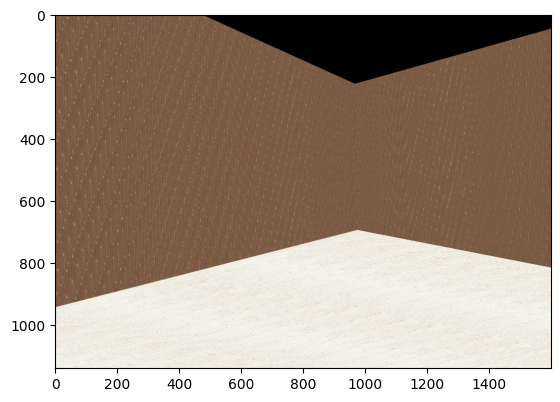

In [4]:
plt.imshow(finalRect)